# Case-study: use of PIC-SURE API to extract data from the CARDIA cohort

## INTRO - Install the required libraries

We install the newly created package picsuRe to facilitate the use of the PIC-SURE API

We also set up the JupyterNB environment

In [14]:
httr::set_config(httr::config(ssl_verifypeer = 0L, ssl_verifyhost = 0L, ssl_verifystatus  = 0L))
if (!file.exists(Sys.getenv("TAR")))  Sys.setenv(TAR = "/bin/tar")

#install.packages("devtools", repos = "http://cran.r-project.org")
#install.packages("reticulate", repos = "http://cran.r-project.org")
#install.packages("ggplot2", repos = "http://cran.r-project.org")
#install.packages("ggthemes",repos = "https://cran.cnr.berkeley.edu/")   

library(devtools)
library(reticulate)
library(ggplot2)
library(ggthemes)

#install_github("hms-dbmi/picsuRe")
#install_github("kaz-yos/tableone")
library(picsuRe)
library(tableone)

## 1. Data extraction
`environment`: The URL of the environment

`key`: To authenticate with PIC-SURE put your key or token in an otherwise empty text file in your JupyterNotebook's top level folder. The key will be read from there so the key does not get seen by anyone except you.

`variables`: A vector with the variables of interest. You can put a variable, or a path, as you want. You can also use the * key if you want to use a wild card. If an argument corresponds to a node, it will return all the variables below the node

In [25]:
env <- "https://topmed-dev.hms.harvard.edu"
key <- as.character(read.table("topmedkey.csv", sep=",")[1,1])

var <- c(Race = "Coronary Artery Risk Development in Young Adults Study Cohort - phs000285/01. demographics/Race (verified at exam 2)",
        Gender = "Coronary Artery Risk Development in Young Adults Study Cohort - phs000285/01. demographics/Sex (verified at exam 2)",
        Age = "Coronary Artery Risk Development in Young Adults Study Cohort - phs000285/01. demographics/Calculated age at exam 1",
        Septal_thickness_systole = "1990-1991 Year 5/02. Clinical data/Cardiology/Echocardiography/M-mode/M-mode: vent septal thickness - systole",
        Has_smoked_cigarettes = "1985-1986 Year 0/01. Medical history/Tobacco, alcohol and drug use/Tobacco use form/Cigarette smoking status",
        Has_used_smokeless_tobacco = "1985-1986 Year 0/01. Medical history/Tobacco, alcohol and drug use/Tobacco use form/05. Subject has used smokeless tobacco")

With the function `picsure`, we build our query, and get the results back from the API. The output is a dataset with the variables of interests. By default, it will return all the patients that have at least one value for a variable.

In [26]:
demo <- picsure(env, key, var)

Next time, try using the token instead of the key. If you want a demo, ask the developpers.
Hi Laura_Versmee thank you for using picsuRe!

Waiting for PIC-SURE to return the query
  ...still waiting
  ...still waiting
  ...still waiting

The data.frame downloaded contains 3622 observations of 7 variables. Its size is 130.8 Kb


## 2. Use the data to make statistics
### 2.a. Summary statistics
Let's take a look at the characteristics of our population

In [29]:
catVars <- c("Race", "Gender", "Has_smoked_cigarettes", "Has_used_smokeless_tobacco")
vars <- c("Race", "Gender", "Age", "Septal_thickness_systole", "Has_smoked_cigarettes", "Has_used_smokeless_tobacco")

paste("We have", nrow(demo), "patients in our population.")
"Table 1: Description of the population from the CARDIA Study"
CreateTableOne(vars, data = demo[,-1], factorVars = catVars, strata = c("Gender"), test = FALSE)

[1] "We have 3622 patients in our population."

[1] "Table 1: Description of the population from the CARDIA Study"

                                      Stratified by Gender
                                       Female        Male          
  n                                     2020          1602         
  Race = White, not Hispanic (%)        1032 (51.1)    909 ( 56.7) 
  Gender = Male (%)                        0 ( 0.0)   1602 (100.0) 
  Age (mean (sd))                      25.06 (3.68)  25.00 (3.55)  
  Septal_thickness_systole (mean (sd))  1.24 (0.20)   1.40 (0.21)  
  Has_smoked_cigarettes (%)                                        
                                          10 ( 0.5)      9 (  0.6) 
     Ex-smokers                          294 (14.6)    195 ( 12.2) 
     Non-smokers                        1171 (58.0)    951 ( 59.4) 
     Smokers                             545 (27.0)    447 ( 27.9) 
  Has_used_smokeless_tobacco (%)                                   
                                          21 ( 1.0)     24 (  1.5) 
     No                                 1990 (98.5)   149

### 2.b. Comparison of a categorical variable with a continuous one.
#### 2.b.1. Comparison of Age among male and female
We want to start by looking at the distribution of age in our population

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  17.00   22.00   25.00   25.04   28.00   34.00 

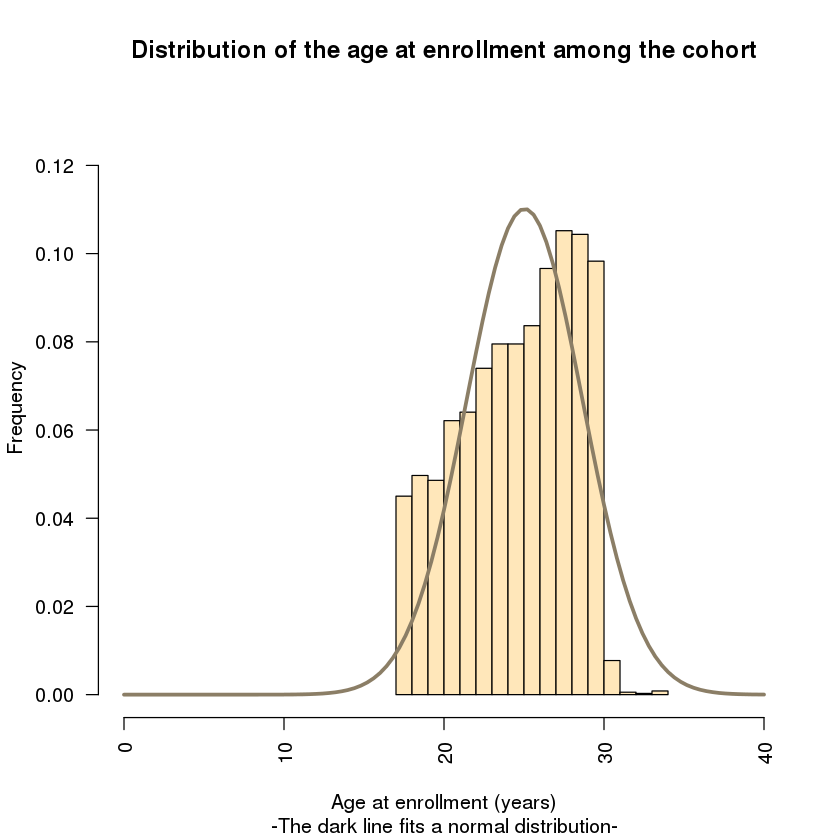

In [32]:
Age <- demo$Age
summary(Age)
hist(Age,
     main="Distribution of the age at enrollment among the cohort",
     sub="-The dark line fits a normal distribution-",
     xlab="Age at enrollment (years)", 
     ylab="Frequency",
     border="black", 
     col="wheat1",
     xlim=c(0,40),
     ylim=c(0,0.13),
     breaks=20,
     las = 2,
     prob = TRUE
    )
m <- mean(Age, na.rm = TRUE)
std <- sqrt(var(Age, na.rm = TRUE))
x <- length(Age)
curve(dnorm(x, mean=m, sd=std), col="wheat4", lwd=3, add=TRUE, yaxt="n")

We can see that the distibution of Age is not normal in our population.

### 2.c. Comparison of 2 categorical variables.
We want to know if gender and usage of smokeless tobacco are correlated.

In [35]:
demo <- demo[((demo$Gender == "Female" | demo$Gender == "Male")
            & (demo$Has_used_smokeless_tobacco == "Yes" | demo$Has_used_smokeless_tobacco == "No")),]
demo <- droplevels(demo)

Smokeless_tobacco_smokers <- demo$Has_used_smokeless_tobacco
Gender <- demo$Gender

TwoByTwo <- table(Gender, Smokeless_tobacco_smokers)
TwoByTwo
chisq.test(Gender, Smokeless_tobacco_smokers)

        Smokeless_tobacco_smokers
Gender     No  Yes
  Female 1990    9
  Male   1493   85


	Pearson's Chi-squared test with Yates' continuity correction

data:  Gender and Smokeless_tobacco_smokers
X-squared = 82.06, df = 1, p-value < 2.2e-16


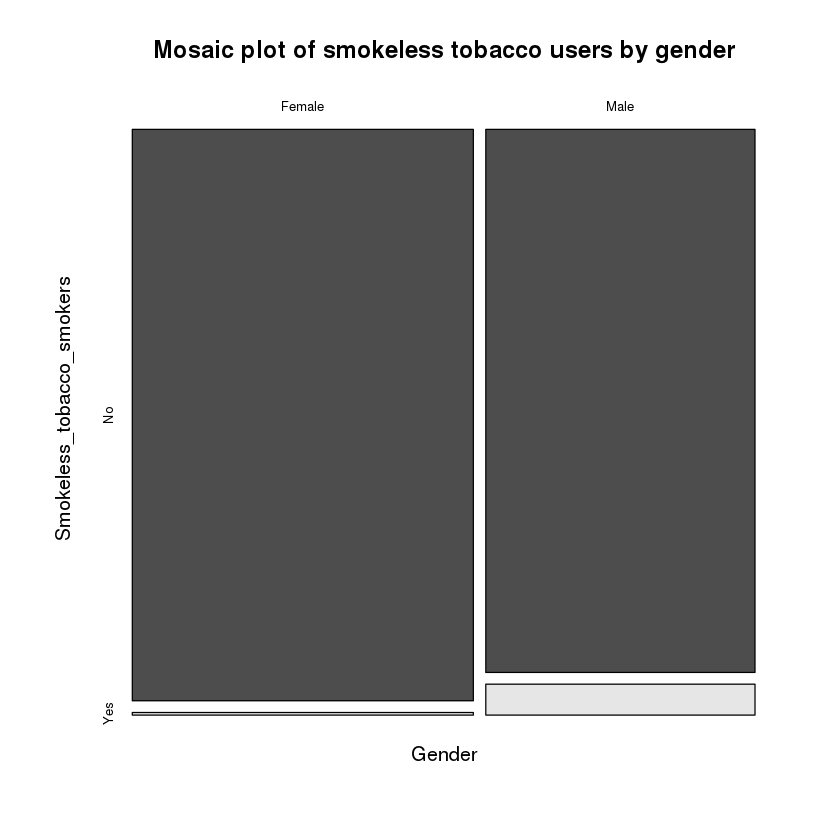

In [34]:
mosaicplot(TwoByTwo, color = TRUE, main = "Mosaic plot of smokeless tobacco users by gender")

The p-value is lower than 0.05, therefore we can conclude that the smokers of smokeless tobacco are statistically significantly lower among the female population of the CARDIA cohort than among the male population. That is also visually significant on the mosaic plot.

### 3. Focus on Myocardial hypertrophy
#### 3.1 Distribution
Histogram showing the distribution of the interventricular septum thickness measurement during the ventricular contraction.

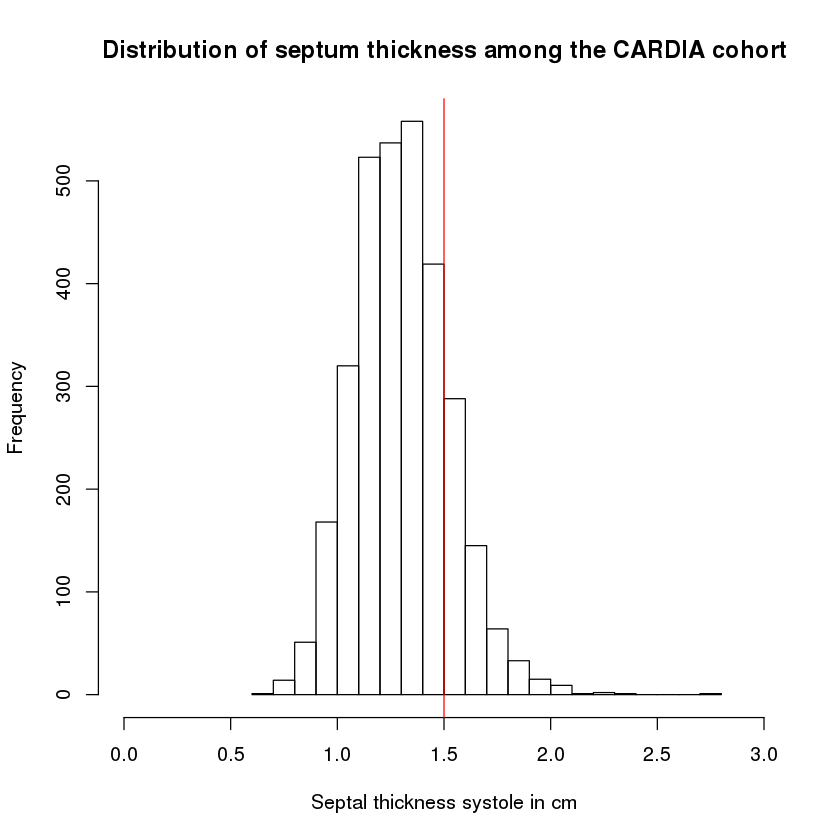

In [41]:
demo <- demo[!(is.na(demo$Septal_thickness_systole)),]
hist(demo$Septal_thickness_systole,
     xlab="Septal thickness systole in cm",
     main = "Distribution of septum thickness among the CARDIA cohort",
     xlim=c(0,3),
     breaks=20)
abline(v=1.5,col="red")

The distribution among our population doesn't seem to fit a bell-shaped curve. It's left-skewed, and with a right tail. The red line drawn at 15mm represent the threshold above which myocardial hypertrophy is defined.

#### 3.2 Comparison between male and female

We can now run a t-test in order to compare the wall thickness of the interventricular septum between whites and african-americans.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.680   1.150   1.300   1.307   1.450   2.740     427 


	Welch Two Sample t-test

data:  Septal_thickness_systole by Race
t = 6.5155, df = 2960.5, p-value = 8.486e-11
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.03588852 0.06678811
sample estimates:
mean in group Black, not Hispanic mean in group White, not Hispanic 
                         1.335049                          1.283711 


Warning message:
: Removed 427 rows containing non-finite values (stat_boxplot).

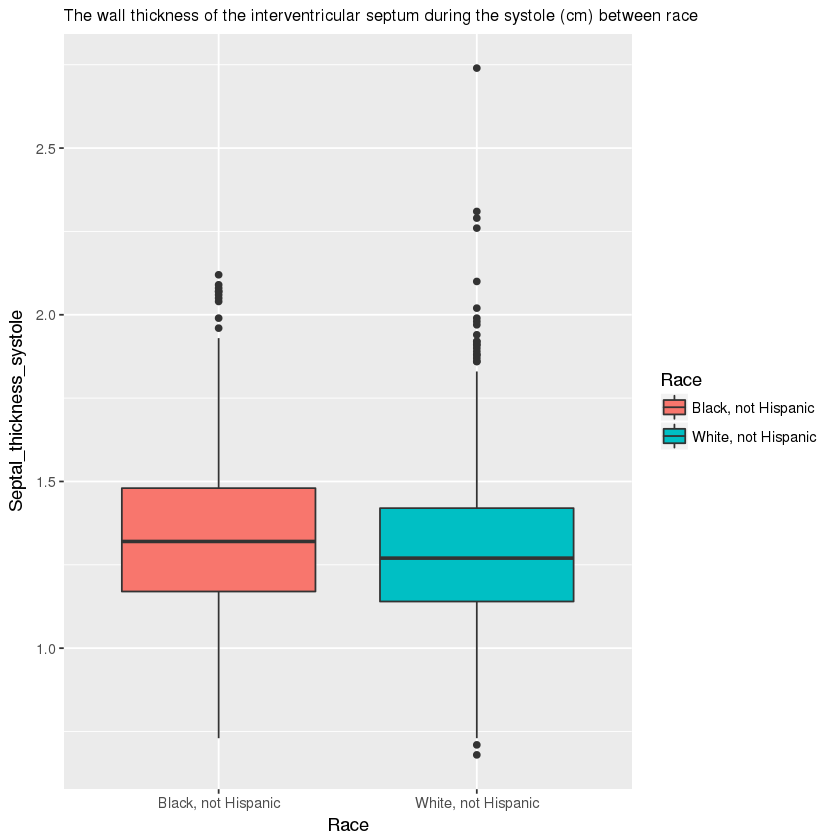

In [11]:
demo2 <- demo[(demo$Race == "White, not Hispanic" | demo$Race == "Black, not Hispanic"),]

Septal_thickness_systole <- demo$Septal_thickness_systole
Race <- demo2$Race

summary(Septal_thickness_systole)

p <- ggplot(demo, aes(x=Race, y=Septal_thickness_systole, fill=Race)) + geom_boxplot()
p + labs(subtitle="The wall thickness of the interventricular septum during the systole (cm) between race")

In [43]:
t.test(Septal_thickness_systole~Race)


	Welch Two Sample t-test

data:  Septal_thickness_systole by Race
t = 6.5155, df = 2960.5, p-value = 8.486e-11
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.03588852 0.06678811
sample estimates:
mean in group Black, not Hispanic mean in group White, not Hispanic 
                         1.335049                          1.283711 


The p-value is lower than 0.05, therefore we can conclude that the interventricular septum thickness is significantly lower among whites subjects of the CARDIA cohort than among african-american.

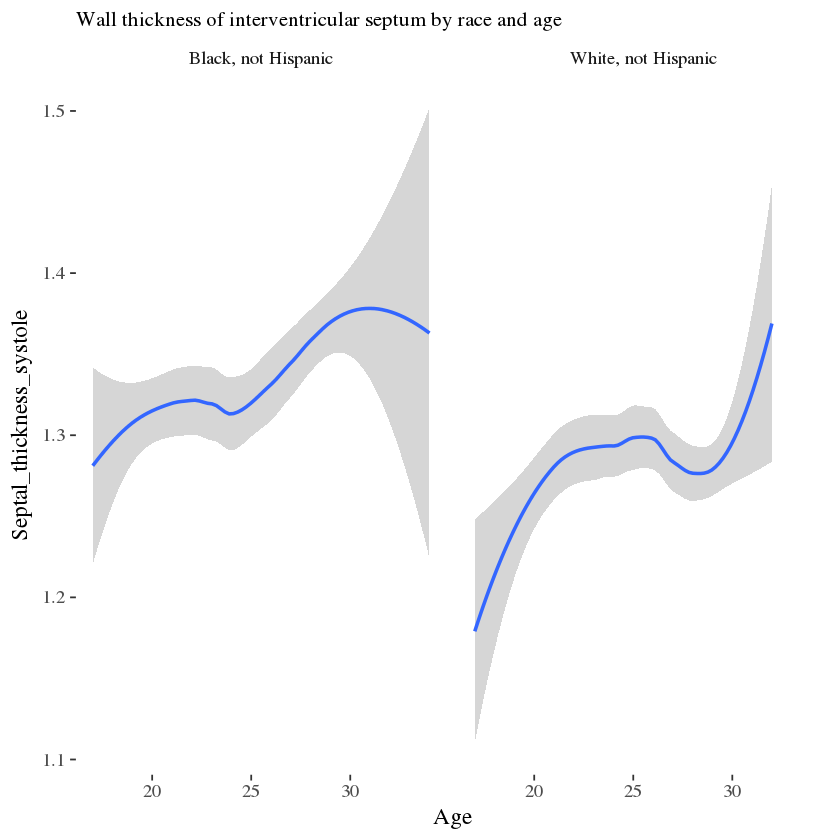

In [42]:
p <- ggplot(data=demo,aes(x=Age,y=Septal_thickness_systole))
p + theme_tufte(base_size=14) + stat_smooth(method='loess') + facet_grid(~Race) + labs(subtitle="Wall thickness of interventricular septum by race and age")

We can see that the wall thickness of the interventricular septum during the systole according to the age is higher in the black population than in the white population, and increases with age.